This notebook is primarily intended to test GPU optimization of the script `volumerender.py`, using the `cupy` library. When running this notebook, don't forget to select a GPU in the Google Colab resources, otherwise the GPU-optimized part will throw errors.

We begin with defining the same functions from the original script, for comparison purposes.

In [17]:
import numpy as np
from scipy.interpolate import interpn, RegularGridInterpolator

def transfer_function(x: np.array) -> tuple:
    """! Transfer function to use for volume rendering.

    @param x: Input density data
    :return: red, green, blue, and opacity value (r,g,b,a)
    """

    r = (
            1.0 * np.exp(-((x - 9.0) ** 2) / 1.0)
            + 0.1 * np.exp(-((x - 3.0) ** 2) / 0.1)
            + 0.1 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    g = (
            1.0 * np.exp(-((x - 9.0) ** 2) / 1.0)
            + 1.0 * np.exp(-((x - 3.0) ** 2) / 0.1)
            + 0.1 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    b = (
            0.1 * np.exp(-((x - 9.0) ** 2) / 1.0)
            + 0.1 * np.exp(-((x - 3.0) ** 2) / 0.1)
            + 1.0 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    a = (
            0.6 * np.exp(-((x - 9.0) ** 2) / 1.0)
            + 0.1 * np.exp(-((x - 3.0) ** 2) / 0.1)
            + 0.01 * np.exp(-((x - -3.0) ** 2) / 0.5)
    )
    return r, g, b, a


def transfer_function_optimized(x: np.array) -> tuple:
    """! Transfer function to use for volume rendering. It is hand-optimized to
    avoid performing the same calculations multiple times.

    @param x: Input density data
    :return: red, green, blue, and opacity value (r,g,b,a)
    """

    temp1 = np.exp(-((x - 9.0) ** 2) / 1.0)
    temp2 = np.exp(-((x - 3.0) ** 2) / 0.1)
    temp3 = np.exp(-((x + 3.0) ** 2) / 0.5)
    r = 1.0 * temp1 + 0.1 * temp2 + 0.1 * temp3
    g = 1.0 * temp1 + 1.0 * temp2 + 0.1 * temp3
    b = 0.1 * temp1 + 0.1 * temp2 + 1.0 * temp3
    a = 0.6 * temp1 + 0.1 * temp2 + 0.01 * temp3
    return r, g, b, a


def render_angle(datacube: np.array, points: tuple, angle: int, n_angles: int, n: int, cli_args) -> np.array:
    """! Render a single angle of the volume rendering.

    @param datacube: 3D datacube of density, opened with h5py and stored in a numpy array
    @param points: 3D grid containing the datacube, tuple (x, y, z) of numpy linear spaces
    @param angle: Angle of the volume rendering (0 <= angle < n_angles)
    @param n_angles: Total number of angles to render
    @param n: Resolution of the camera grid
    @param cli_args: CLI arguments
    """

    print("Rendering Scene " + str(angle + 1) + " of " + str(n_angles) + ".")

    new_angle = np.pi / 2 * angle / n_angles
    c = np.linspace(-n / 2, n / 2, n)
    qx, qy, qz = np.meshgrid(c, c, c)
    qx_r = qx
    qy_r = qy * np.cos(new_angle) - qz * np.sin(new_angle)
    qz_r = qy * np.sin(new_angle) + qz * np.cos(new_angle)
    qi = np.array([qx_r.ravel(), qy_r.ravel(), qz_r.ravel()]).T

    # Interpolate onto camera grid
    if cli_args.interpolate_func == "scipy":
        camera_grid = interpn(points, datacube, qi, method="linear").reshape((n, n, n))
    elif cli_args.interpolate_func == "scipy2":
        interpolator = RegularGridInterpolator(points, datacube, method="linear")
        camera_grid = interpolator(qi).reshape((n, n, n))
    else:
        raise ValueError("Unknown interpolation function.")

    # Perform volume rendering
    image = np.zeros((camera_grid.shape[1], camera_grid.shape[2], 3))

    for dataslice in camera_grid:
        if cli_args.transfer_func == "original":
            r, g, b, a = transfer_function(np.log(dataslice))
        elif cli_args.transfer_func == "hand-optimized":
            r, g, b, a = transfer_function_optimized(np.log(dataslice))
        else:
            raise ValueError("Unknown transfer function.")

        image[:, :, 0] = a * r + (1 - a) * image[:, :, 0]
        image[:, :, 1] = a * g + (1 - a) * image[:, :, 1]
        image[:, :, 2] = a * b + (1 - a) * image[:, :, 2]

    image = np.clip(image, 0.0, 1.0)

    if cli_args.render:
        plt.figure(figsize=(4, 4), dpi=80)

        plt.imshow(image)
        plt.axis("off")

        # Save figure
        plt.savefig(
            "data/img/volumerender" + str(angle) + ".png",
            dpi=240,
            bbox_inches="tight",
            pad_inches=0,
        )
    return image

We also define the `main` method, which will call all sub-methods using the given arguments `cli_args` as a Namespace instance.

In [18]:
import h5py as h5
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Pool

def main_numpy(cli_args):
    """! Main function to run the volume rendering with the given CLI arguments.

    @param cli_args: CLI arguments
    """

    # Load datacube
    f = h5.File("data/datacube.hdf5", "r")
    datacube = np.array(f["density"])
    output = []

    # Datacube grid
    n_x, n_y, n_z = datacube.shape
    x = np.linspace(-n_x / 2, n_x / 2, n_x)
    y = np.linspace(-n_y / 2, n_y / 2, n_y)
    z = np.linspace(-n_z / 2, n_z / 2, n_z)
    points = (x, y, z)

    # Perform volume rendering for each angle
    n_angles = 10

    # Serial volume rendering
    if cli_args.parallel == "serial":
        print("Rendering in serial.")
        for i in range(n_angles):
            output.append(render_angle(datacube, points, i, n_angles, 180, cli_args))

    # Parallel volume rendering using concurrent futures
    elif cli_args.parallel == "concurrent-futures":
        print("Rendering in parallel using concurrent-futures.")
        with ProcessPoolExecutor(max_workers=cli_args.num_workers) as executor:
            results = [
                executor.submit(render_angle, datacube, points, i, n_angles, 180, cli_args)
                for i in range(n_angles)
            ]
            for result in results:
                output.append(result.result())

    # Parallel volume rendering using multiprocessing
    elif cli_args.parallel == "multiprocessing":
        print("Rendering in parallel using multiprocessing")
        with Pool(cli_args.num_workers) as pool:
            results = [
                pool.apply_async(render_angle, (datacube, points, i, n_angles, 180, cli_args))
                for i in range(n_angles)
            ]
            for result in results:
                output.append(result.get())

    if cli_args.render:
        plt.figure(figsize=(4, 4), dpi=80)
        plt.imshow(np.log(np.mean(datacube, 0)), cmap="viridis")
        plt.clim(-5, 5)
        plt.axis("off")
        plt.savefig("data/img/projection.png", dpi=240, bbox_inches="tight", pad_inches=0)

    if cli_args.plot:
        plt.show()

    return output

Now, we also define an optimized version for GPU computations. This uses the `cupy` library, which can be seen as the `numpy` equivalent providing vectorized computations executable on GPU, which are faster. We also use the `cupyx.scipy` library, which provides the necessary `interpn` function, optimized for GPUs.

In [19]:
import cupy as cp
from cupyx.scipy.interpolate import interpn as interpn_cupy

def transfer_function_cupy(x: cp.array) -> tuple:
    """! Transfer function to use for volume rendering.

    @param x: Input density data
    :return: red, green, blue, and opacity value (r,g,b,a)
    """


    r = (
        1.0 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.1 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    g = (
        1.0 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 1.0 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.1 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    b = (
        0.1 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 1.0 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    a = (
        0.6 * cp.exp(-((x - 9.0) ** 2) / 1.0)
        + 0.1 * cp.exp(-((x - 3.0) ** 2) / 0.1)
        + 0.01 * cp.exp(-((x - -3.0) ** 2) / 0.5)
    )
    return r, g, b, a


def transfer_function_optimized_cupy(x: cp.array) -> tuple:
    """! Transfer function to use for volume rendering.

    @param x: Input density data
    :return: red, green, blue, and opacity value (r,g,b,a)
    """

    temp1 = cp.exp(-((x - 9.0) ** 2) / 1.0)
    temp2 = cp.exp(-((x - 3.0) ** 2) / 0.1)
    temp3 = cp.exp(-((x + 3.0) ** 2) / 0.5)
    r = 1.0 * temp1 + 0.1 * temp2 + 0.1 * temp3
    g = 1.0 * temp1 + 1.0 * temp2 + 0.1 * temp3
    b = 0.1 * temp1 + 0.1 * temp2 + 1.0 * temp3
    a = 0.6 * temp1 + 0.1 * temp2 + 0.01 * temp3
    return r, g, b, a


def render_angle_cupy(datacube: cp.array, points: cp.array, angle: int, n_angles: int, n: int, cli_args) -> cp.array:
    """! Render a single angle of the volume rendering.

    @param datacube: 3D datacube of density, opened with h5py and stored in a cupy array
    @param points: 3D grid containing the datacube, tuple (x, y, z) of cupy linear spaces
    @param angle: Angle of the volume rendering (0 <= angle < n_angles)
    @param n_angles: Total number of angles to render
    @param n: Resolution of the camera grid
    @param cli_args: CLI arguments
    """

    print("Rendering Scene " + str(angle + 1) + " of " + str(n_angles) + ".")

    angle = cp.pi / 2 * angle / n_angles
    c = cp.linspace(-n / 2, n / 2, n)
    qx, qy, qz = cp.meshgrid(c, c, c)
    qx_r = qx
    qy_r = qy * cp.cos(angle) - qz * cp.sin(angle)
    qz_r = qy * cp.sin(angle) + qz * cp.cos(angle)
    qi = cp.array([qx_r.ravel(), qy_r.ravel(), qz_r.ravel()]).T

    # Interpolate onto camera grid
    if cli_args.interpolate_func == "scipy":
        camera_grid = interpn_cupy(points, datacube, qi, method="linear").reshape((n, n, n))
    elif cli_args.interpolate_func == "scipy2":
        interpolator = RegularGridInterpolator(points, datacube, method="linear")
        camera_grid = interpolator(qi).reshape((n, n, n))
    else:
        raise ValueError("Unknown interpolation function")

    # Perform volume rendering
    image = cp.zeros((camera_grid.shape[1], camera_grid.shape[2], 3))

    for dataslice in camera_grid:
        # Use correct transfer function
        if cli_args.transfer_func == "original":
            r, g, b, a = transfer_function_cupy(cp.log(dataslice))
        elif cli_args.transfer_func == "hand-optimized":
            r, g, b, a = transfer_function_optimized_cupy(cp.log(dataslice))
        else:
            raise ValueError("Unknown transfer function")

        image[:, :, 0] = a * r + (1 - a) * image[:, :, 0]
        image[:, :, 1] = a * g + (1 - a) * image[:, :, 1]
        image[:, :, 2] = a * b + (1 - a) * image[:, :, 2]

    image = cp.clip(image, 0.0, 1.0)

    if cli_args.render:
        plt.figure(figsize=(4, 4), dpi=80)
        plt.imshow(image.get().astype('float32'))
        plt.axis("off")
        plt.savefig(
            "data/img/volumerender" + str(angle) + ".png",
            dpi=240,
            bbox_inches="tight",
            pad_inches=0,
        )
    return image

Finally, as for the `numpy` implementation, we define the `main` method which will call the above, using the `cli_args` argument as a Namespace instance.

In [20]:
def main_cupy(cli_args):
    """! Main function to run the volume rendering with the given CLI arguments.

    @param cli_args: CLI arguments
    """

    # Load datacube
    f = h5.File("data/datacube.hdf5", "r")
    datacube = cp.array(f["density"])
    output = []

    # Datacube grid
    n_x, n_y, n_z = datacube.shape
    x = cp.linspace(-n_x / 2, n_x / 2, n_x)
    y = cp.linspace(-n_y / 2, n_y / 2, n_y)
    z = cp.linspace(-n_z / 2, n_z / 2, n_z)
    points = (x, y, z)

    # Perform volume rendering for each angle
    n_angles = 10

    # Serial volume rendering
    if cli_args.parallel == "serial":
        print("Rendering in serial.")
        for i in range(n_angles):
            output.append(render_angle_cupy(datacube, points, i, n_angles, 180, cli_args))

    # Parallel volume rendering using concurrent futures
    elif cli_args.parallel == "concurrent-futures":
        print("Rendering in parallel using concurrent-futures.")
        with ProcessPoolExecutor(max_workers=cli_args.num_workers) as executor:
            results = [
                executor.submit(render_angle_cupy, datacube, points, i, n_angles, 180, cli_args)
                for i in range(n_angles)
            ]
            for result in results:
                output.append(result.result())

    # Parallel volume rendering using multiprocessing
    elif cli_args.parallel == "multiprocessing":
        print("Rendering in parallel using multiprocessing")
        with Pool(cli_args.num_workers) as pool:
            results = [
                pool.apply_async(render_angle_cupy, (datacube, points, i, n_angles, 180, cli_args))
                for i in range(n_angles)
            ]
            for result in results:
                output.append(result.get())

    if cli_args.render:
        plt.figure(figsize=(4, 4), dpi=80)
        plt.imshow(cp.log(cp.mean(datacube, 0)).get(), cmap="viridis")
        plt.clim(-5, 5)
        plt.axis("off")
        plt.savefig("data/img/projection.png", dpi=240, bbox_inches="tight", pad_inches=0)

    if cli_args.plot:
        plt.show()

    return output

We also define a method for parsing arguments needed to submit several versions of our computation. We can call this method each time we want to define arguments for our functions `main_numpy` or `main_cupy`. Setting the flag `--cupy` will perform a computation using GPU optimization.

In [21]:
def parse_arguments():
    parser = argparse.ArgumentParser(description="Volume Rendering Optimization")

    parser.add_argument(
        "--no-render",
        action="store_false",
        dest="render",
        help="Do not render the results into images",
    )
    parser.add_argument(
        "--no-plot",
        action="store_false",
        dest="plot",
        help="Do not plot the results"
    )
    parser.add_argument(
        "--transfer-function",
        default="original",
        choices=["original", "hand-optimized", "cython"],
        dest="transfer_func",
        help="Transfer function to use",
    )
    parser.add_argument(
        "--interpolate-function",
        default="scipy",
        choices=["scipy", "scipy2"],
        dest="interpolate_func",
        help="Interpolation function to use",
    )
    parser.add_argument(
        "--parallel",
        default="serial",
        choices=["serial", "concurrent-futures", "multiprocessing"],
        dest="parallel",
        help="Use parallel processing",
    )

    # Number of workers in parallel processing
    parser.add_argument(
        "--num-workers",
        default=8,
        type=int,
        dest="num_workers",
        help="Number of workers to use in parallel processing",
    )

    # Use cupy optimization
    parser.add_argument(
        "--cupy",
        action="store_true",
        dest="cupy",
        help="run the cupy version",
    )

    return parser.parse_args()

Now, we can define our second module `perfbench.py` to benchmark the execution times of our different versions of the same function. We skip the `compare_data` function since it would force us to dowload all the original data.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from timeit import default_timer as timer

def time_function(fn: callable, num_iters: int = 1) -> callable:
    """! Measures the time of the function fn.

    @param fn: The function to measure the time of
    @param num_iters: The number of iterations to measure the time
    :return a callable function that returns mean and standard deviation of
    the execution time, as well as the output in a tuple
    """

    def measure_time(*args, **kwargs):
        execution_times = np.empty((num_iters,))
        output = np.zeros((1, 1, 1))
        for i in range(num_iters):
            t1 = timer()
            output = fn(*args, **kwargs)
            t2 = timer()
            execution_times[i] = t2 - t1
        mean = np.mean(execution_times)
        std = np.std(execution_times)
        return mean, std, output

    return measure_time


def call_version(cli_args) -> callable:
    """! Simple method to choose whether to use the main function optimized for GPUs with `cupy` or not.

    @param cli_args: CLI arguments
    """
    if cli_args.cupy:
      return main_cupy(cli_args)
    else :
      return main_numpy(cli_args)


def plot_versions(*versions: tuple):
    """! Plot the performance of given versions as a horizontal bar chart
    with the mean execution time and standard deviation.

    @param versions: A tuple of elements, each containing parameters for one specific version
    """
    version = []
    for name, args_ in versions:
        print("--------------------------------------------------")
        mean, std, out = time_function(call_version, num_iters=1)(args_)
        version.append((name, mean, std))
        print("")

    # Now we plot the results
    _, ax = plt.subplots()
    y_pos = np.arange(len(version))
    names, means, stds = zip(*version)

    ax.barh(y_pos, means, xerr=stds, align="center", color="#69CD67", ecolor="black")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.set_xlabel("Time (s)")
    ax.set_title("Performance comparison")
    plt.show()


def plot_time(*versions: tuple):
    """! Print the mean and standard deviation of the execution time of given versions.

    @param versions: A tuple of elements, each containing parameters for one specific version
    """
    for name, args in versions:
        mean, std, output = time_function(call_version)(args)
        print(f"{name} : {mean}s +- {std}")

def parallel_workers_comparison(parallel: str, start: int, end: int):
    """! Compare the performance of the parallel versions of the script with different number of workers.

    @param parallel: Either "concurrent-futures" or "multiprocessing", the parallelization method to use
    @param start: The number of workers to start with
    @param end: The number of workers to end with
    """
    if parallel not in ["concurrent-futures", "multiprocessing"]:
        raise ValueError("parallel must be 'concurrent-futures' or 'multiprocessing'")
    versions = []
    for i in range(start, end + 1):
        versions.append(
            (
                f"v4_parallel_{i}_workers",
                argparse.Namespace(
                    render=False,
                    plot=False,
                    transfer_func="hand-optimized",
                    interpolate_func="scipy",
                    parallel=parallel,
                    num_workers=i,
                ),
            )
        )
    plot_versions(*versions)

Let's define all the versions (i.e. sets of parameters) we want to compare. We will define some using `cupy`, some using `multiprocessing`, some using the `hand-optimimized` version of the `transfer-func`, etc.

In [23]:
v0_original = (
    "v0_original",
    argparse.Namespace(
        render=False,
        plot=False,
        transfer_func="original",
        interpolate_func="scipy",
        parallel="serial",
        cupy=False
    ),
)
v1_hand_optimized = (
    "v1_hand_optimized",
    argparse.Namespace(
        render=False,
        plot=False,
        transfer_func="hand-optimized",
        interpolate_func="scipy",
        parallel="serial",
        cupy=False
    ),
)
v2_scipy2 = (
    "v2_scipy2",
    argparse.Namespace(
        render=False,
        plot=False,
        transfer_func="hand-optimized",
        interpolate_func="scipy2",
        parallel="serial",
        cupy=False
    ),
)
v3_parallel = (
    "v3_parallel",
    argparse.Namespace(
        render=False,
        plot=False,
        transfer_func="hand-optimized",
        interpolate_func="scipy",
        parallel="concurrent-futures",
        num_workers=8,
        cupy=False
    ),
)
v4_parallel = (
    "v4_parallel",
    argparse.Namespace(
        render=False,
        plot=False,
        transfer_func="hand-optimized",
        interpolate_func="scipy",
        parallel="multiprocessing",
        num_workers=8,
        cupy=False
    ),
)

v5_original_cupy = (
    "v5_original_cupy",
    argparse.Namespace(
        render=False,
        plot=False,
        transfer_func="original",
        interpolate_func="scipy",
        parallel="serial",
        cupy=True
    )
)

v6_hand_optimized_cupy = (
    "v6_hand_optimized_cupy",
    argparse.Namespace(
        render=False,
        plot=False,
        transfer_func="hand-optimized",
        interpolate_func="scipy",
        parallel="serial",
        cupy=True
    )
)

Now, we can run the comparison of all previously defined versions running the next cell.

--------------------------------------------------
Rendering in serial.
Rendering Scene 1 of 10.
Rendering Scene 2 of 10.
Rendering Scene 3 of 10.
Rendering Scene 4 of 10.
Rendering Scene 5 of 10.
Rendering Scene 6 of 10.
Rendering Scene 7 of 10.
Rendering Scene 8 of 10.
Rendering Scene 9 of 10.
Rendering Scene 10 of 10.

--------------------------------------------------
Rendering in serial.
Rendering Scene 1 of 10.
Rendering Scene 2 of 10.
Rendering Scene 3 of 10.
Rendering Scene 4 of 10.
Rendering Scene 5 of 10.
Rendering Scene 6 of 10.
Rendering Scene 7 of 10.
Rendering Scene 8 of 10.
Rendering Scene 9 of 10.
Rendering Scene 10 of 10.

--------------------------------------------------
Rendering in serial.
Rendering Scene 1 of 10.
Rendering Scene 2 of 10.
Rendering Scene 3 of 10.
Rendering Scene 4 of 10.
Rendering Scene 5 of 10.
Rendering Scene 6 of 10.
Rendering Scene 7 of 10.
Rendering Scene 8 of 10.
Rendering Scene 9 of 10.
Rendering Scene 10 of 10.

----------------------------

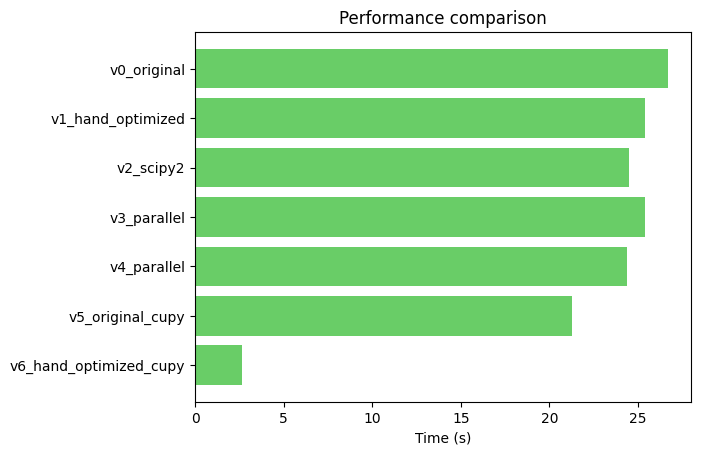

In [24]:
# Plot all the versions
plot_versions(v0_original, v1_hand_optimized, v2_scipy2, v3_parallel, v4_parallel, v5_original_cupy, v6_hand_optimized_cupy)